# Stock Forecasting using ML

For this project I will train a machine learning model, more especifically a gradient boosting model, to predict the performance of stocks. The data will be collected using the yfinance library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('fivethirtyeight')

## Loading Data and Understanding Dataset

In [3]:
nflx_df = yf.download('NFLX', start='2005-01-01', end='2024-1-1', progress=False)

In [4]:
nflx_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.800000,1.800000,1.645714,1.702857,1.702857,11334400
2005-01-04,1.702857,1.707143,1.607143,1.665714,1.665714,17352300
2005-01-05,1.677143,1.677143,1.584286,1.600000,1.600000,12732300
2005-01-06,1.600000,1.624286,1.572857,1.578571,1.578571,8273300
2005-01-07,1.587143,1.650000,1.571429,1.588571,1.588571,7490700


In [5]:
print(f'Dataframe contains {nflx_df.shape[0]} rows and {nflx_df.shape[1]} columns')
print('\nLet us check for missing values:')
nflx_df.isnull().sum().sum()

Dataframe contains 4781 rows and 6 columns

Let us check for missing values:


0

In [6]:
# some summary statistics
nflx_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,150.285681,152.604171,147.894085,150.308280,150.308280,1.577663e+07
std,178.054246,180.585164,175.370681,178.011041,178.011041,1.816095e+07
min,1.300000,1.317143,1.272857,1.290000,1.290000,1.144000e+06
25%,6.707143,6.841429,6.597143,6.707143,6.707143,5.974500e+06
50%,56.175713,57.495712,55.357143,56.972858,56.972858,9.807900e+06
75%,297.899994,301.799988,291.690002,297.570007,297.570007,1.864310e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.155418e+08


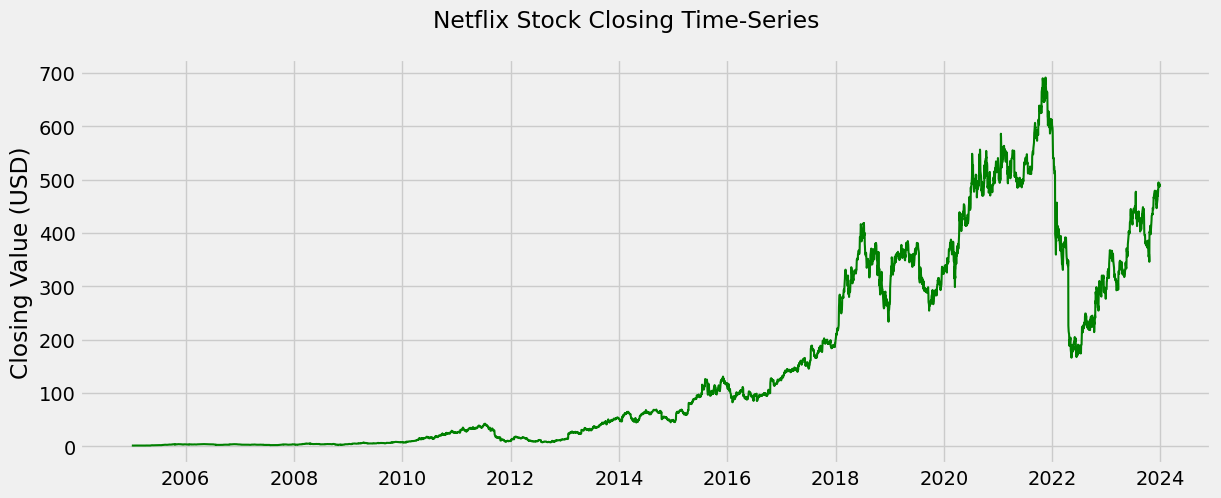

In [5]:
fig = plt.figure(figsize=(13,5))
plt.plot(nflx_df.index, nflx_df.Close, color='green', linewidth=1.5)
plt.ylabel('Closing Value (USD)')
plt.suptitle('Netflix Stock Closing Time-Series')

plt.show()

## Feature Engineering



In [6]:
# Our model will use data from previous days as features to predict the Closing value for the current day

# Let's define a function to create the dataframe we will need to train the model
def create_model_df(stock_df, days):
  df = stock_df[['Close']].copy()

  for i in range(1, days+1):
    df[f'Close_t-{i}'] = df.Close.shift(i)

  df['moving_avg'] = df.Close.shift(1).rolling(days).mean()
  df['moving_std'] = df.Close.shift(1).rolling(days).std()

  #df.bfill(inplace=True)

  # Another option: Since the Close column is getting shifted downwards, the first days rows will have null values
  # Rather than filling in the missing data with values that may affect the model's performance,
  # I can drop the rows since it is just a couple of rows in comparison with our data size
  #df.dropna
  return df.dropna(axis=0)

In [7]:
df = create_model_df(nflx_df, 7)

In [8]:
df.head(10)

,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5,Close_t-6,Close_t-7,moving_avg,moving_std
Date,,,,,,,,,,
2005-01-12,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.665714,1.702857,1.616939,0.048847
2005-01-13,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.665714,1.593061,0.039876
2005-01-14,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.600000,1.576735,0.026234
2005-01-18,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.578571,1.579388,0.029691
2005-01-19,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.588571,1.584490,0.032466
2005-01-20,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.610000,1.583469,0.032428
2005-01-21,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.572857,1.579796,0.030309
2005-01-24,1.591429,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.535714,1.580408,0.030189
2005-01-25,1.618571,1.591429,1.577143,1.584286,1.581429,1.614286,1.618571,1.551429,1.588368,0.022908


## Training Models

#### Baseline Model: Linear Regression

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor


X = df[['Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5', 'Close_t-6', 'Close_t-7', 'moving_avg', 'moving_std']]
y = df['Close']

In [10]:
cv = TimeSeriesSplit(n_splits=5)

regressor = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.1,  #0.001, 0.0001
    n_estimators=1000,  #1000, 200
    max_depth=6,
    verbose=1

)

for train_index, test_index in cv.split(df):
    # Extract the train and test sets based on the split indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=predictions)
    mae = mean_absolute_error(y_true=y_test, y_pred=predictions)

    print(f"\nMSE: {mse} \nMAE: {mae}")
    print("-" * 30)

      Iter       Train Loss   Remaining Time 
         1           0.4989            6.18s
         2           0.4053            5.60s
         3           0.3295            5.37s
         4           0.2681            5.35s
         5           0.2182            5.40s
         6           0.1777            5.46s
         7           0.1450            5.41s
         8           0.1183            5.36s
         9           0.0968            5.52s
        10           0.0792            5.44s
        20           0.0126            5.00s
        30           0.0036            5.01s
        40           0.0020            4.88s
        50           0.0014            4.81s
        60           0.0011            4.81s
        70           0.0008            4.71s
        80           0.0007            4.82s
        90           0.0006            4.75s
       100           0.0004            4.69s
       200           0.0001            4.04s
       300           0.0000            3.50s
       40

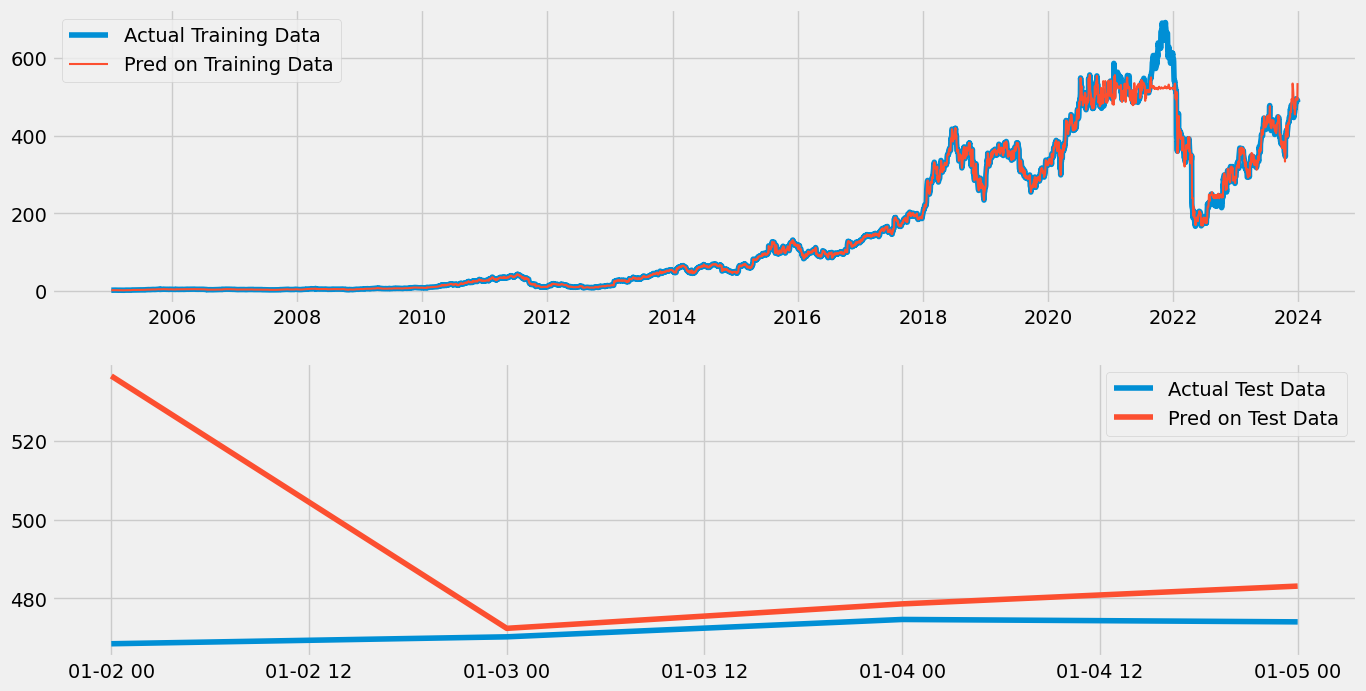

In [12]:
## TEST with Netflix data

preds = regressor.predict(X)
netflix_unseen = yf.download('NFLX', start='2023-01-01', end='2024-1-6', progress=False)
netflix_unseen = create_model_df(netflix_unseen, days=7)
netflix_unseen = netflix_unseen[netflix_unseen.index > nflx_df.index.max()]

netflix_unseen_preds = regressor.predict(netflix_unseen.iloc[:, 1:])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

# this should do very well since it is the data it was trained on
ax1.plot(df.index, df.Close, label='Actual Training Data')
ax1.plot(df.index, preds, label='Pred on Training Data', linewidth = 1.5)

# unseen data, however there is very little unseen data since there is not much data from January
ax2.plot(netflix_unseen.index, netflix_unseen.Close, label= 'Actual Test Data')
ax2.plot(netflix_unseen.index, netflix_unseen_preds, label= 'Pred on Test Data')

ax1.legend()
ax2.legend()

plt.show()

## Testing with other companies

In [81]:
def test_with_company(stock_symbol, regressor):
  df = yf.download(stock_symbol, start='2005-01-01', end='2024-1-5', progress=False) #2005-01-01 2023-11-01
  df = create_model_df(df, 7)
  preds = regressor.predict(df.iloc[:, 1:])

  print(f'MAE: {mean_absolute_error(df.Close, preds)} \nMSE: {mean_squared_error(df.Close, preds)} \n', '-' * 35)

  fig, ax = plt.subplots(figsize=(15,8))

  ax.plot(df.index, df.Close, label='Actual data')
  ax.plot(df.index, preds, label='Prediction', linewidth=1.5)
  ax.set_ylabel('Closing Price (USD)')
  ax.set_title(f'Predicting {stock_symbol.upper()} Stock')

  ax.legend()

  plt.show()

MAE: 5.542179808776482 
MSE: 63.542163781392716 
 -----------------------------------


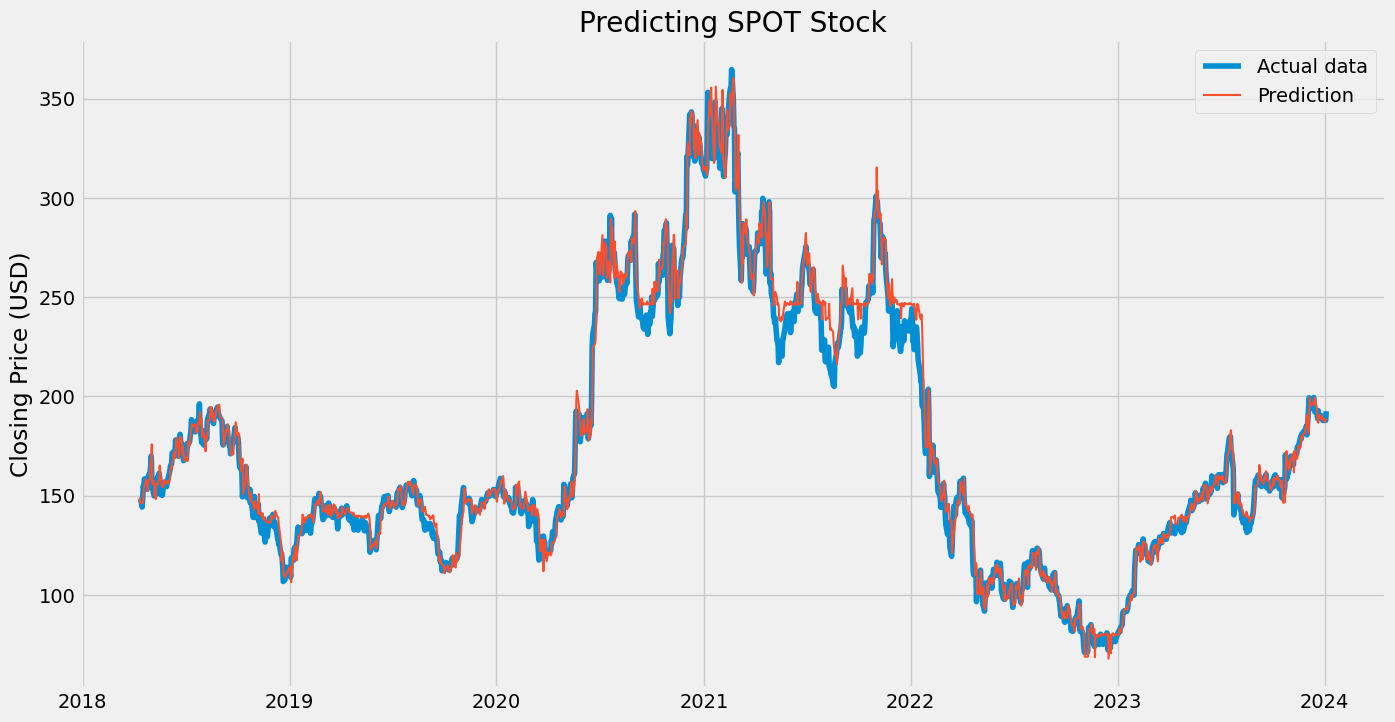

In [82]:
test_with_company('SPOT', regressor)

MAE: 2.83228128397171 
MSE: 42.883969746652284 
 -----------------------------------


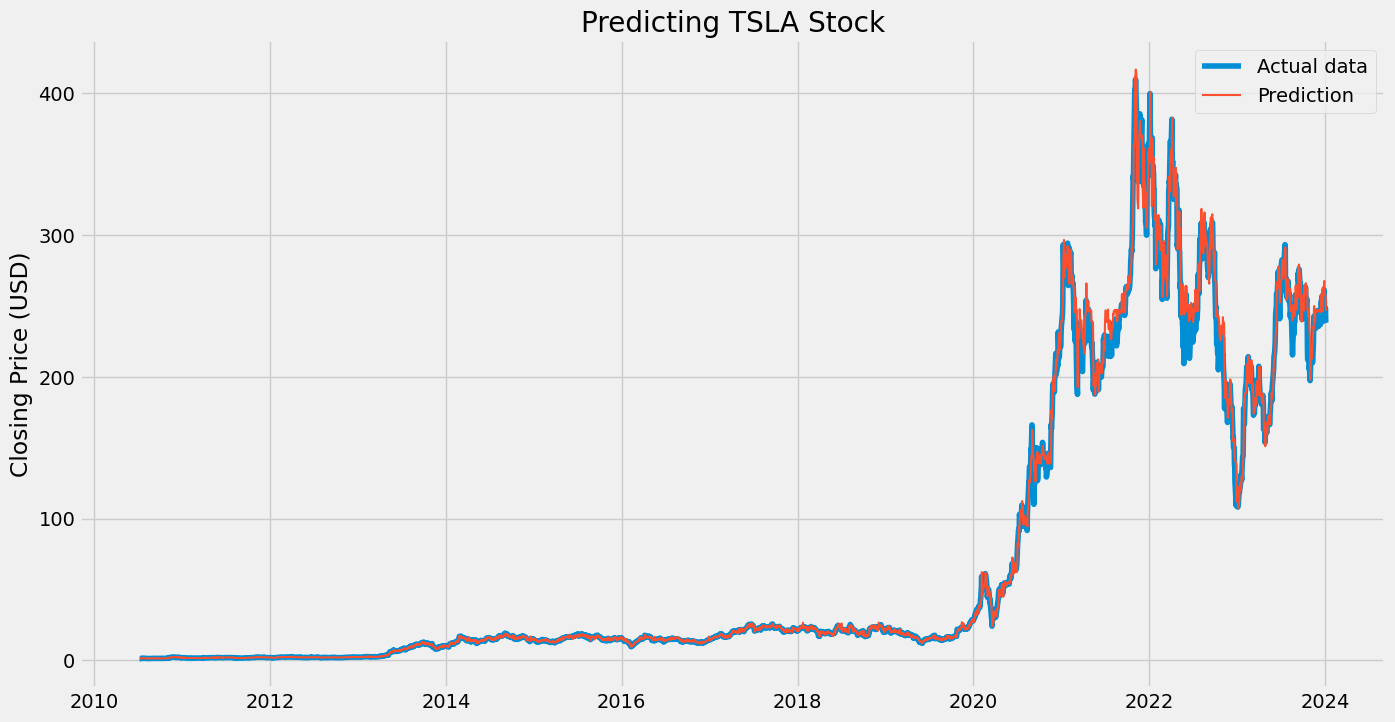

In [94]:
test_with_company('TSLA', regressor)

MAE: 2.032983000088924 
MSE: 15.751008368502385 
 -----------------------------------


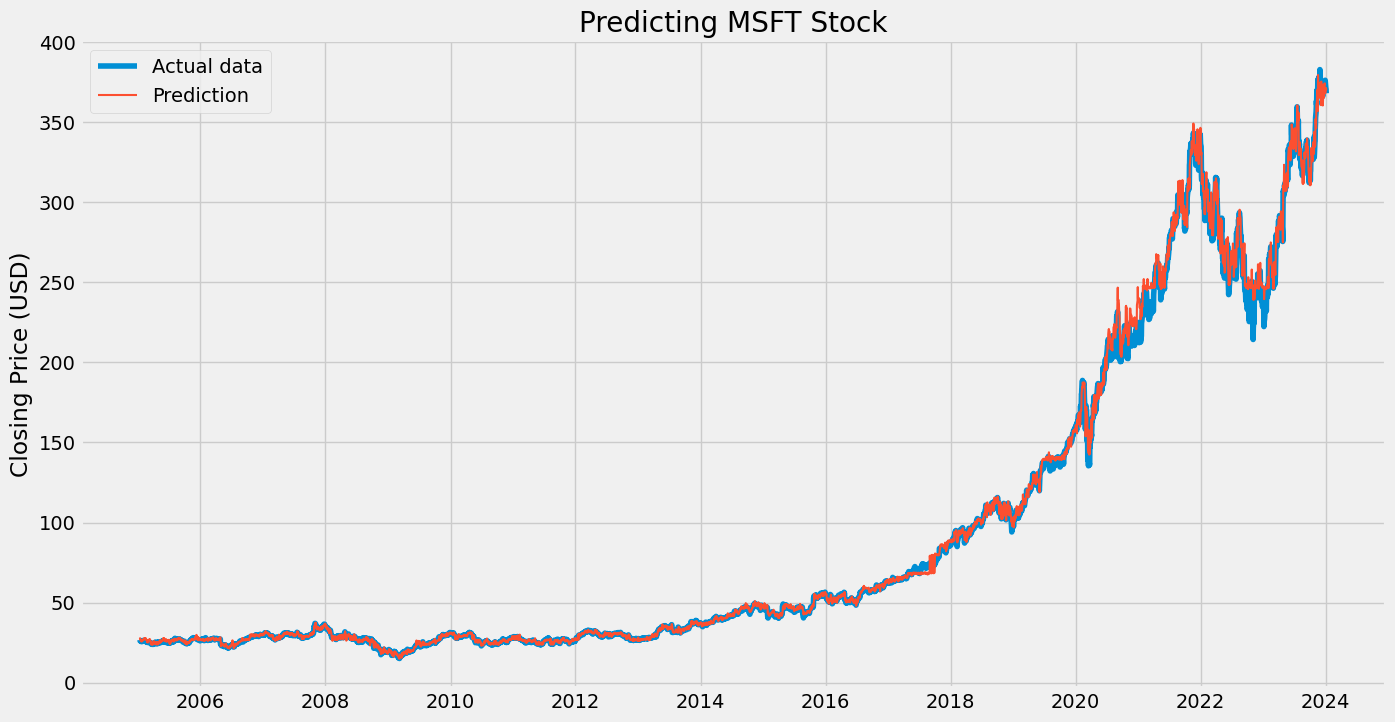

In [97]:
test_with_company('MSFT', regressor)

MAE: 0.18619838155537688 
MSE: 0.07353068979132847 
 -----------------------------------


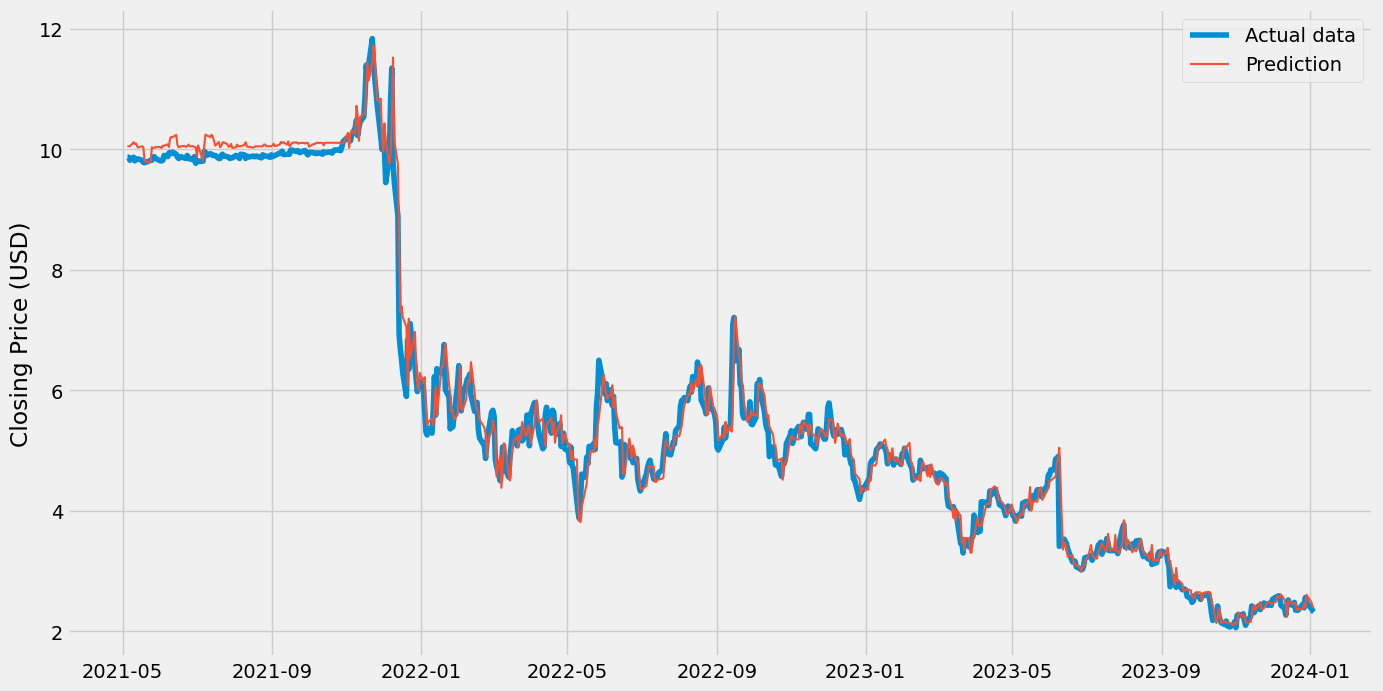

In [24]:
test_with_company('PL', regressor)

MAE: 0.4353728653131056 
MSE: 2.6179056000641046 
 -----------------------------------


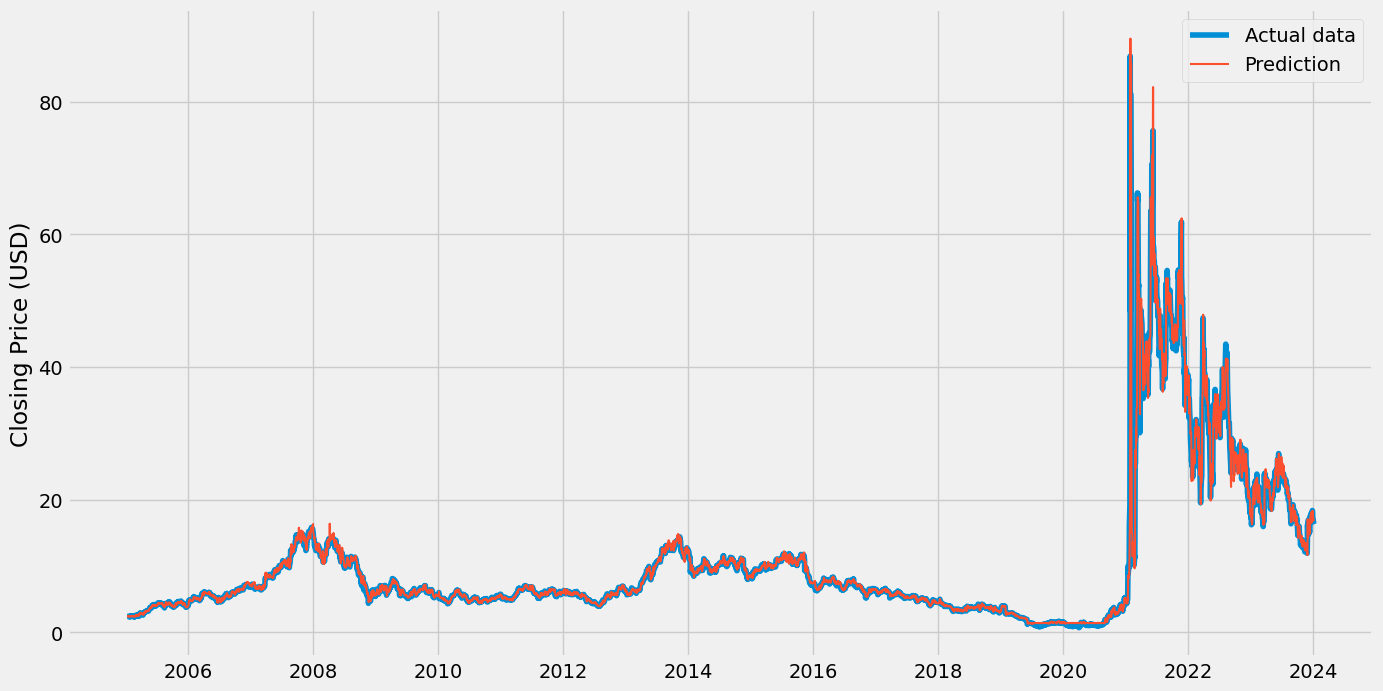

In [27]:
test_with_company('gme', regressor)

MAE: 1487.476603296452 
MSE: 4994790.622573561 
 -----------------------------------


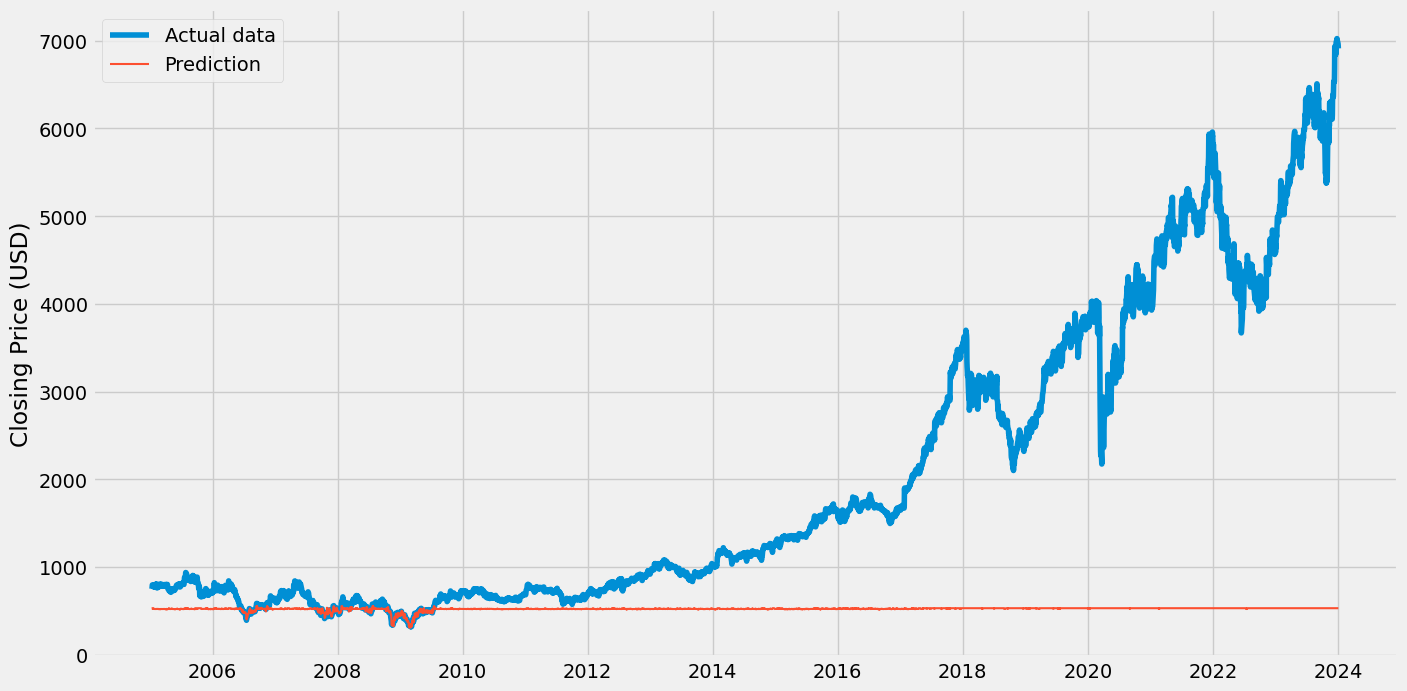

In [30]:
test_with_company('nvr', regressor)

## Forecasting two decade's worth of data for a couple of stocks

In [85]:
def forecast(stock_symbol, regressor):

  # query some baseline data in order to calculate lagged features, avg and std
  df = yf.download(stock_symbol, '2023-12-1', '2024-1-6', progress=False)
  df = create_model_df(df, 7)

  # Get the first day of our

  # define time interval for which we will forecast
  n_days = 365 * 10  # let's start out with one decade for now

  # calculate features, then score, and repeat n_days times
  for day in range(n_days):
    date = df.iloc[-1].name + pd.Timedelta(days=1)

    if day == 0:
      first_day = date

    new_row = pd.DataFrame(columns=df.columns, index=[date])

    for i in range(7):
      new_row[f'Close_t-{i+1}'] = df.Close.shift(i).iloc[-1]

    new_row['moving_avg'] = new_row.iloc[-1, 1:-2].mean()
    new_row['moving_std'] = new_row.iloc[-1, 1:-2].std()

    new_row['Close'] = regressor.predict(new_row.iloc[:, 1:])

    df = pd.concat([df, new_row])

  # get forecasted data only
  df_forecasted = df[df.index >= first_day]

  fig, ax = plt.subplots(figsize=(15, 8))

  ax.plot(df_forecasted.index, df_forecasted.Close)

  ax.set_title(f'Forecasting for {stock_symbol.upper()} Stock')
  ax.set_ylabel('Closing Price (USD)')


  plt.show()

  # return df_forecasted

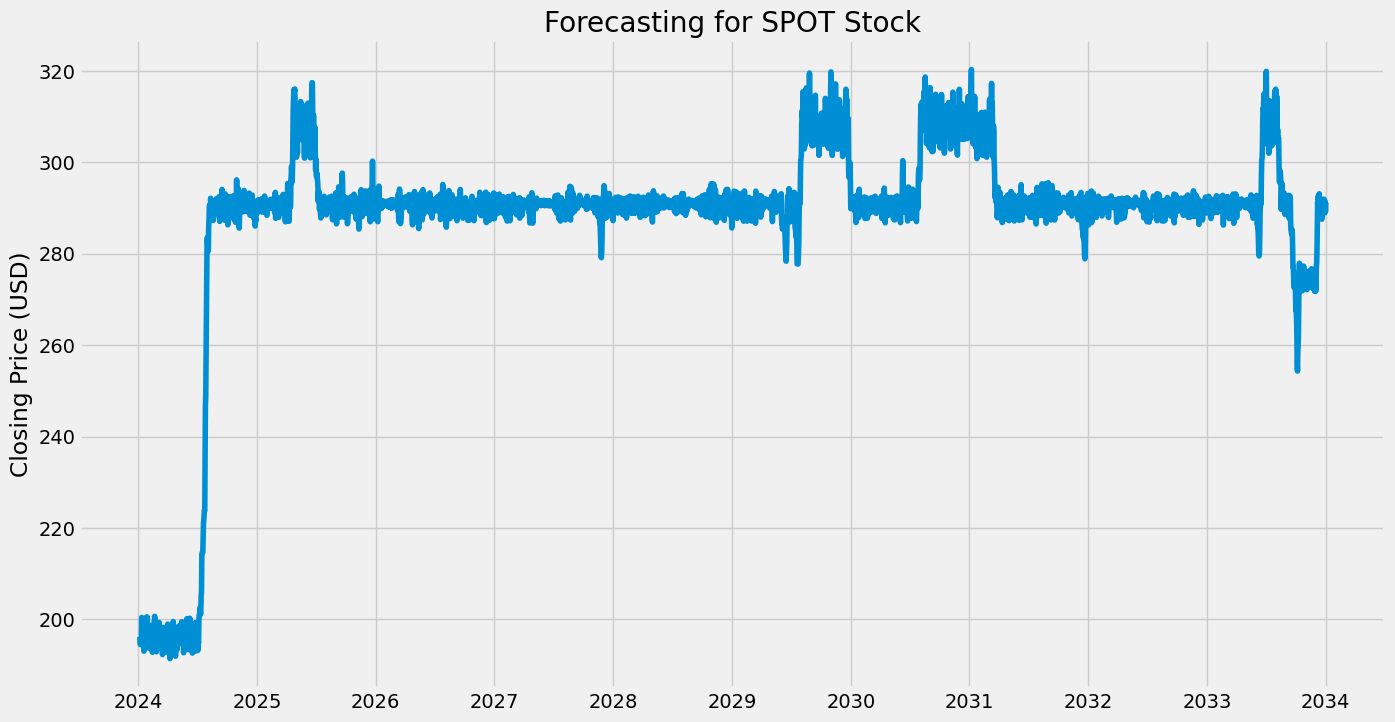

In [86]:
forecast('SPOT', regressor)  # Spotify

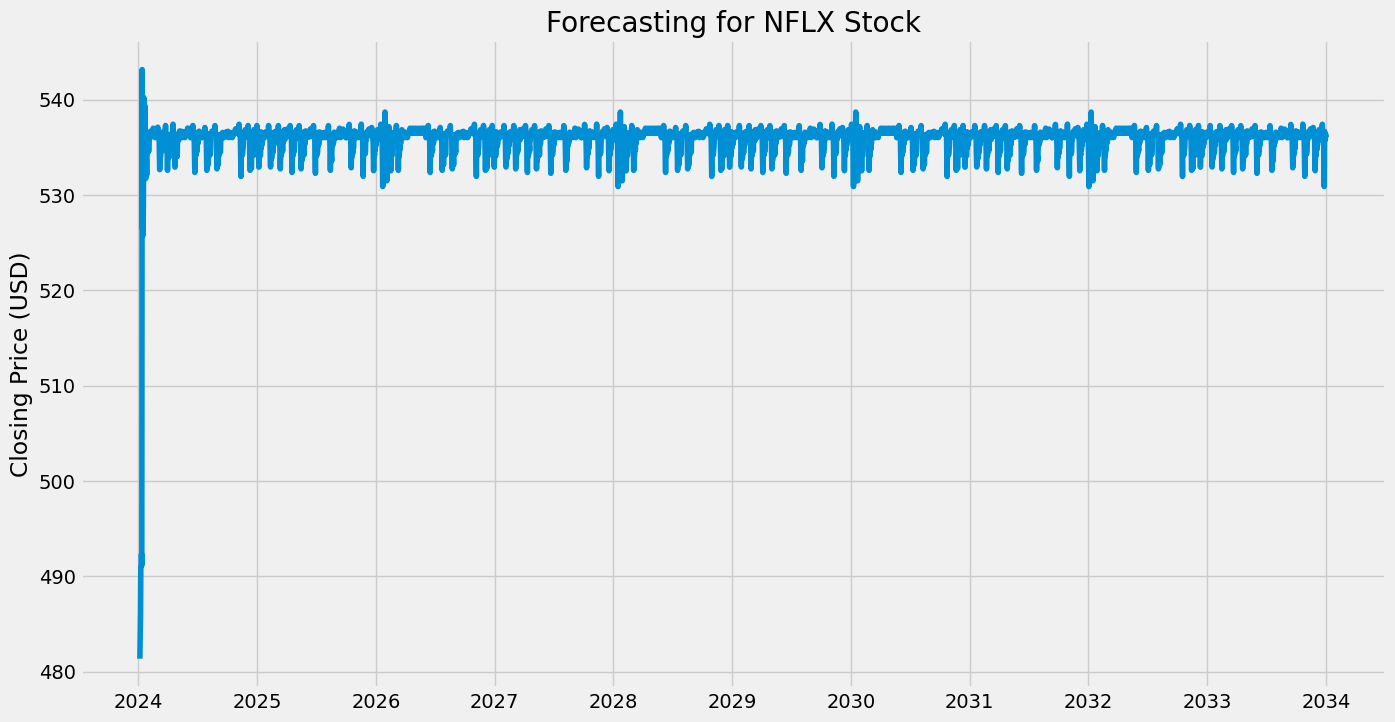

In [87]:
forecast('NFLX', regressor)  # Netflix

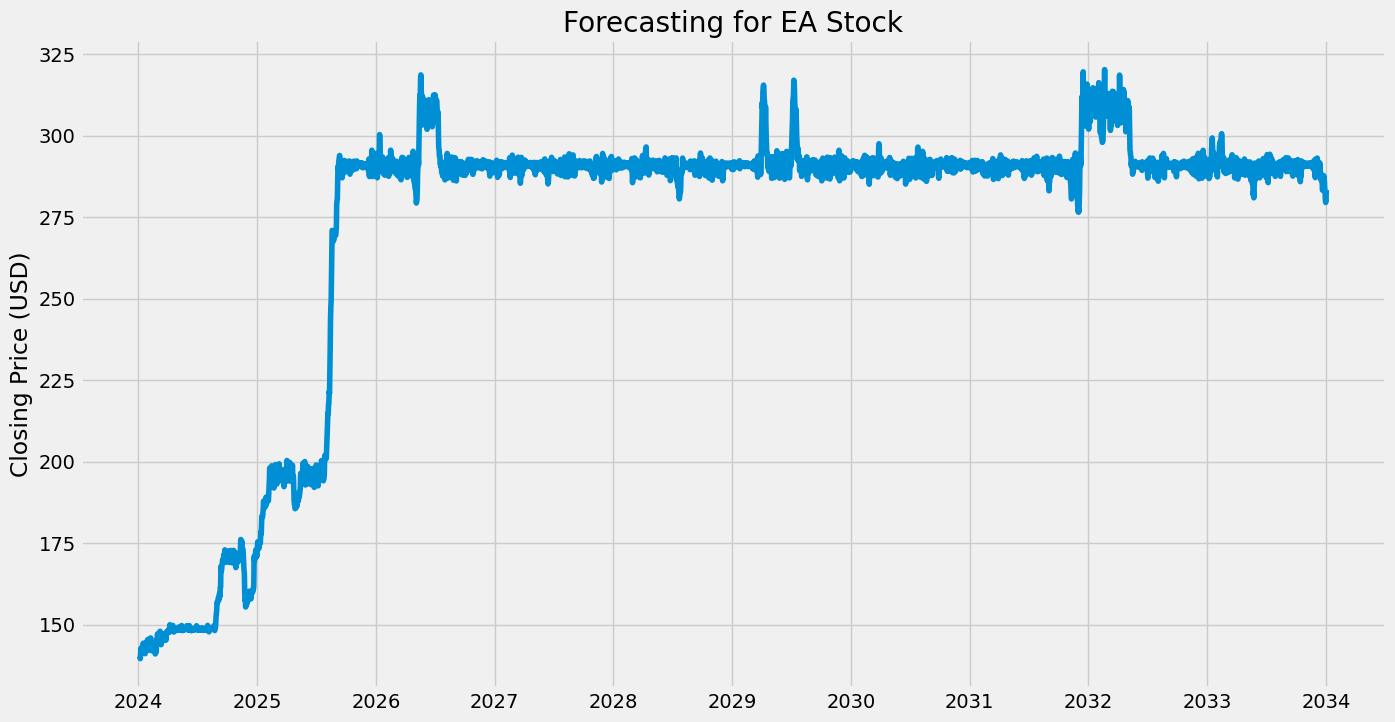

In [92]:
forecast('ea', regressor)  # Electronic Arts

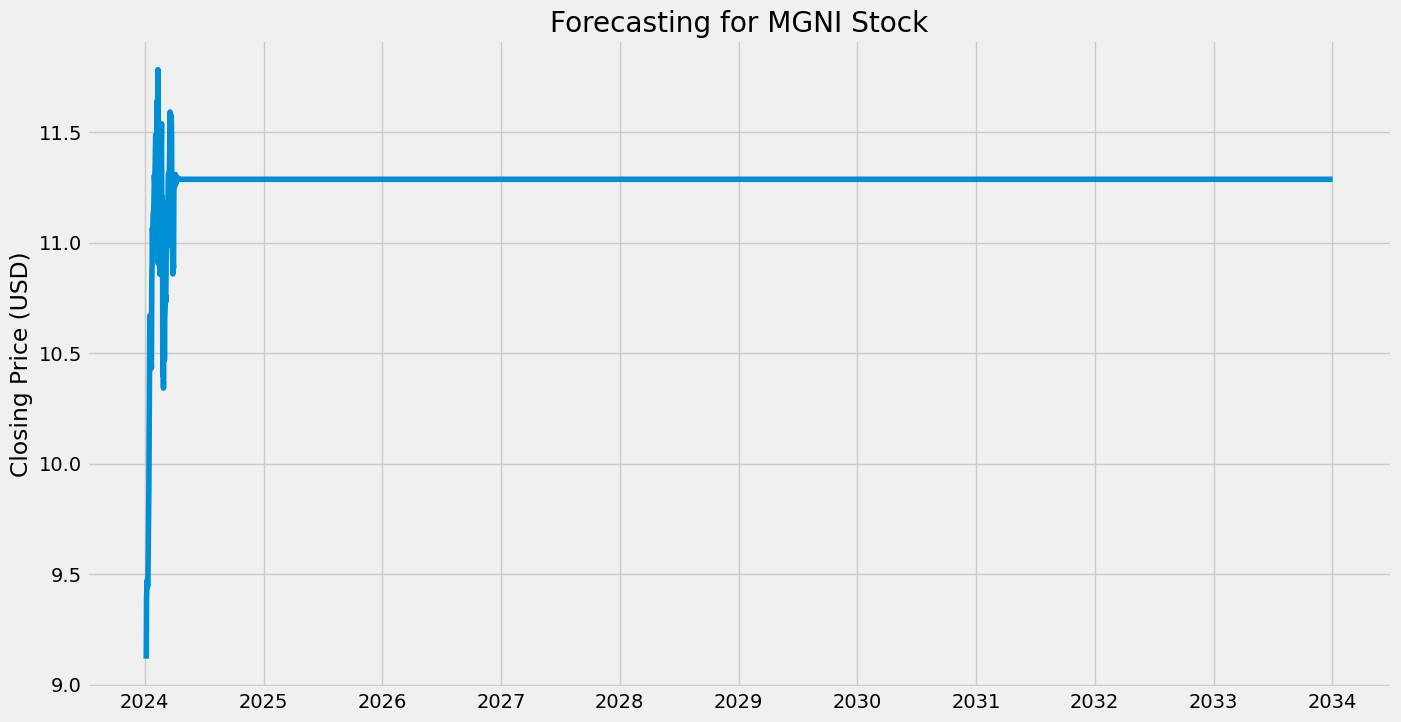

In [93]:
forecast('mgni', regressor)  # Magnite Inc

## Conclusion

Although the model performed well at predicting historical data for the most part, it seems like it has issues once the prices go above a certain threshold as can be seen in the NVR stock graph for example. This is definitely an area for future improvement. When it comes to forecasting, EA and Spotify's predictions seem plausible, while the Netflix and Magnite Inc forecasts are hard to believe. Nonetheless, the results are better than I expected.

Next steps:
- Retraining model with new data that captures a wider margin when it comes to the price, and/or implement feature scaling as well
- Evaluating different models such as neural networks and comparing performances